### Initialize notebook

In [2]:
#!/home/akhanal1/Spring2018/pl-env/bin/python3.5
# Torch imports

import os
import sys
sys.path.append('/home/ak/Spring2018/ature')
os.chdir('/home/ak/Spring2018/ature')

import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
import PIL.Image as IMG

from torch.utils.data.sampler import WeightedRandomSampler
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import numpy as np

from commons.segmentation import AtureTest
from commons.IMAGE import SegmentedImage


from utils import img_utils as imgutil
from commons.IMAGE import Image
from neuralnet.unet.unet_trainer import UnetNNTrainer
from neuralnet.unet.unet_dataloader import ImageGenerator
from neuralnet.unet.model.unet import UNet

%load_ext autoreload
%autoreload 2

/home/ak/anaconda/envs/ature_env/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
### Define folders. Create if needed.
sep = os.sep
Dirs = {}
Dirs['checkpoint']   = 'assests' +sep+ 'nnet_models'
Dirs['data']      = 'data'+sep+'DRIVE'+sep+'training'
Dirs['images']    = Dirs['data'] +sep+ 'images'
Dirs['mask']      = Dirs['data'] +sep+ 'mask'
Dirs['truth']     = Dirs['data'] +sep+ '1st_manual'

TestDirs = {}
TestDirs['data']      = 'data'+sep+'DRIVE'+sep+'test'
TestDirs['images']    = TestDirs['data'] +sep+ 'test_images'
TestDirs['mask']      = TestDirs['data'] +sep+ 'mask'
TestDirs['truth']     = TestDirs['data'] +sep+ '1st_manual'

ValidationDirs = {}
ValidationDirs['data']      = 'data'+sep+'DRIVE'+sep+'test'
ValidationDirs['images']    = ValidationDirs['data'] +sep+ 'validation_images'
ValidationDirs['mask']      = ValidationDirs['data'] +sep+ 'mask'
ValidationDirs['truth']     = ValidationDirs['data'] +sep+ '1st_manual'

for k, folder in Dirs.items():
    os.makedirs(folder, exist_ok=True)
for k, folder in TestDirs.items():
    os.makedirs(folder, exist_ok=True)
for k, folder in ValidationDirs.items():
    os.makedirs(folder, exist_ok=True)

def get_mask_file(file_name): 
    return file_name.split('_')[0] + '_training_mask.gif'

def get_ground_truth_file(file_name): 
    return file_name.split('_')[0] + '_manual1.gif'

def get_mask_file_test(file_name): 
    return file_name.split('_')[0] + '_test_mask.gif'

train_image_size = (380, 380)
classes = { 'background': 0, 'vessel': 1,}
batch_size = 2
num_classes = len(classes)
num_channels = 1


epochs = 5
use_gpu = False

#### Images to train/validate per epoch ####
train_size = 50000
validation_size = 5000
checkpoint_file = 'PytorchCheckpoint51.nn.tar'

### Define the network

In [4]:
net = UNet(num_channels, num_classes)
optimizer = optim.Adam(net.parameters(), lr=0.0001)

In [5]:
# net

### Load train data

In [6]:
transform = transforms.Compose([
        imgutil.whiten_image2d,
        transforms.ToPILImage(),
#         transforms.RandomHorizontalFlip(),
#         transforms.RandomRotation(5),
#         transforms.RandomVerticalFlip(),
        transforms.ToTensor()
    ])

trainset = ImageGenerator(Dirs=Dirs,
                          transform=transform,
                          fget_mask=get_mask_file,
                          fget_truth=get_ground_truth_file, train_image_size=train_image_size) 

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
                                          shuffle=False, num_workers=3)

### 20 images found.


### Load Validation Data

In [7]:
transform_val = transforms.Compose([
        imgutil.whiten_image2d,
        transforms.ToPILImage(),
        transforms.ToTensor()
    ])

validation_set = ImageGenerator(Dirs=ValidationDirs,
                                transform=transform_val,
                                fget_mask=get_mask_file_test,
                                fget_truth=get_ground_truth_file, train_image_size=train_image_size) 

validationloader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, 
                                            shuffle=False, num_workers=3)

### 3 images found.


### Train and evaluate the Network

In [8]:
trainer = UnetNNTrainer(model=net, checkpoint_dir=Dirs['checkpoint'], checkpoint_file=checkpoint_file)
# trainer.resume_from_checkpoint()
trainer.train(optimizer=optimizer, dataloader=trainloader, epochs=epochs, use_gpu=use_gpu, 
              validationloader=validationloader, log_frequency=1)
# trainer.resume_from_checkpoint()

Training...
Epochs:[1/5] Batches:[1/10]  LOSS:1.083 precision:0.138 recall:0.817 f1:0.237 supp:0.000
Epochs:[1/5] Batches:[2/10]  LOSS:1.022 precision:0.161 recall:0.871 f1:0.272 supp:0.000
Epochs:[1/5] Batches:[3/10]  LOSS:0.966 precision:0.164 recall:0.855 f1:0.275 supp:0.000
Epochs:[1/5] Batches:[4/10]  LOSS:1.006 precision:0.119 recall:0.860 f1:0.210 supp:0.000
Epochs:[1/5] Batches:[5/10]  LOSS:0.914 precision:0.154 recall:0.867 f1:0.261 supp:0.000
Epochs:[1/5] Batches:[6/10]  LOSS:0.897 precision:0.144 recall:0.928 f1:0.250 supp:0.000
Epochs:[1/5] Batches:[7/10]  LOSS:0.806 precision:0.189 recall:0.790 f1:0.304 supp:0.000
Epochs:[1/5] Batches:[8/10]  LOSS:0.751 precision:0.215 recall:0.767 f1:0.336 supp:0.000
Epochs:[1/5] Batches:[9/10]  LOSS:0.880 precision:0.155 recall:0.839 f1:0.261 supp:0.000
Epochs:[1/5] Batches:[10/10]  LOSS:0.749 precision:0.208 recall:0.746 f1:0.325 supp:0.000

Evaluating...
Batch[2/2] Precision:0.156 Recall:0.089 F1:0.113 Supp:0.000
Final  #Precision:0.20

/home/ak/anaconda/envs/ature_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Epochs:[2/5] Batches:[8/10]  LOSS:0.418 precision:0.000 recall:0.000 f1:0.000 supp:0.000
Epochs:[2/5] Batches:[9/10]  LOSS:0.360 precision:0.000 recall:0.000 f1:0.000 supp:0.000
Epochs:[2/5] Batches:[10/10]  LOSS:0.388 precision:0.000 recall:0.000 f1:0.000 supp:0.000

Evaluating...
Batch[2/2] Precision:0.000 Recall:0.000 F1:0.000 Supp:0.000
Final  #Precision:0.000 #Recall:0.000 #F1:0.000 #Supp:0.000
Score did not improve. _was:0.097
Epochs:[3/5] Batches:[1/10]  LOSS:0.426 precision:0.000 recall:0.000 f1:0.000 supp:0.000
Epochs:[3/5] Batches:[2/10]  LOSS:0.499 precision:0.000 recall:0.000 f1:0.000 supp:0.000
Epochs:[3/5] Batches:[3/10]  LOSS:0.470 precision:0.000 recall:0.000 f1:0.000 supp:0.000
Epochs:[3/5] Batches:[4/10]  LOSS:0.350 precision:0.000 recall:0.000 f1:0.000 supp:0.000
Epochs:[3/5] Batches:[5/10]  LOSS:0.385 precision:0.000 recall:0.000 f1:0.000 supp:0.000
Epochs:[3/5] Batches:[6/10]  LOSS:0.351 precision:0.000 recall:0.000 f1:0.000 supp:0.000
Epochs:[3/5] Batches:[7/10]  

### Test on a image

In [9]:
transform_test = transforms.Compose([
        imgutil.whiten_image2d,
        transforms.ToPILImage(),
        transforms.ToTensor()
    ])

testset = ImageGenerator(Dirs=TestDirs,
                         transform=transform_test,
                         fget_mask=get_mask_file_test,
                         fget_truth=get_ground_truth_file, train_image_size=train_image_size) 

testloader = torch.utils.data.DataLoader(testset, batch_size=100, 
                                          shuffle=False, num_workers=3)

### 1 images found.


In [10]:
y_scores, y_pred, y_true = trainer.evaluate(dataloader=testloader, use_gpu=use_gpu, force_checkpoint=False)
# mnt.plot_confusion_matrix(y_pred=y_pred, y_true=y_true, classes=classes)


Evaluating...
Batch[1/1] Precision:0.000 Recall:0.000 F1:0.000 Supp:0.000
Final  #Precision:0.000 #Recall:0.000 #F1:0.000 #Supp:0.000


/home/ak/anaconda/envs/ature_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [13]:
ig = y_pred.squeeze() * 255

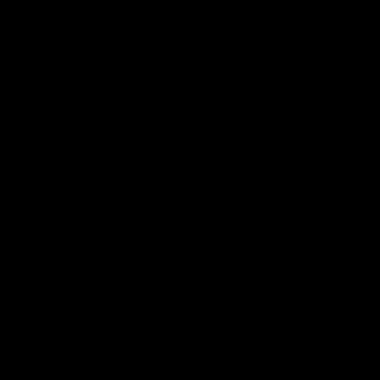

In [14]:
IMG.fromarray(ig.astype(np.uint8))

In [ ]:
IMG.fromarray(ig.astype(np.uint8))

### Convolve throughout the image to generate segmented image based on trained Network

In [ ]:
# sc = np.exp(scores.copy())
# seg = np.zeros(testset.images[0].working_arr.shape)
# for val in zip(IDs, IJs, sc):
#     image_id, (i, j), (b_prob, v_prob) = val
#     seg[i, j] = 255 * v_prob

In [ ]:
IMG.fromarray(seg.astype(np.uint8)).save(checkpoint_file+testset.images[0].file_name+'.png')

In [ ]:
params = {'sk_threshold': 150,
          'alpha': 7.0,
          'orig_contrib': 0.3,
          'seg_threshold': 24}

img_obj = SegmentedImage()

img_obj.load_file(data_dir=TestDirs['images'], file_name='01_test.tif')
img_obj.res['orig'] = img_obj.image_arr[:, :, 1]
# img_obj.working_arr = 255 - seg.astype(np.uint8)

# img_obj.load_mask(mask_dir=TestDirs['mask'], fget_mask=get_mask_file_test, erode=True)
# img_obj.load_ground_truth(gt_dir=TestDirs['truth'], fget_ground_truth=get_ground_truth_file)

# img_obj.generate_skeleton(threshold=params['sk_threshold'])
# img_obj.generate_lattice_graph()

In [ ]:
# tester = AtureTest(out_dir='')
# tester.run(params=params, save_images=False, img_obj=img_obj)
# img_obj.res['scores']